In [ ]:
import os
import numpy as np
import tensorflow as tf
import shutil
import glob as glob
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/mu2mech_final_data_with_testing.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_90.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_100.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_110.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_120.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_130.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_140.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_150.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_160.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_170.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_180.00.png  
  inflating: /content/mu2mech_

In [ ]:

train_images_list = []
from tkinter import Tcl

compositions = ['0.37%', '0.4%', '0.43%', '0.45%', '0.47%', '0.5%','0.35%', '0.25%', '0.3%', '0.33%']

# compositions = ['0.25%', '0.3%','0.37%', '0.4%', '0.45%', '0.47%', '0.5%','0.33%']
for i in range(0,10):
  comp = compositions[i]
  X_train = glob.glob("/content/mu2mech_final_data/5time_step/" + comp +"/*.png")
  # X_train = Tcl().call('lsort', '-dict', X_train)
  X_train = X_train[:500]
  for img in X_train:
    train_images_list.append(img)

#printing the number of images
print(len(train_images_list))
#1k images

#printing the dimensions
img = cv2.imread(train_images_list[0])
dims = img.shape
print(dims)


5000
(128, 128, 3)


In [ ]:
#Reshaping the image into proper input dormat for the autoencoder
from PIL import Image

train_images= []

for i,path in enumerate(train_images_list):
  image = cv2.imread(train_images_list[i],cv2.COLOR_BGR2RGB)
  img = np.array(image)
  img = img.astype("float32")/255.
  train_images.append(img)

print(len(train_images))
print(train_images[0].shape)

5000
(128, 128, 3)


In [ ]:
train_images = np.array(train_images)

(4000, 128, 128, 3)
(500, 128, 128, 3)


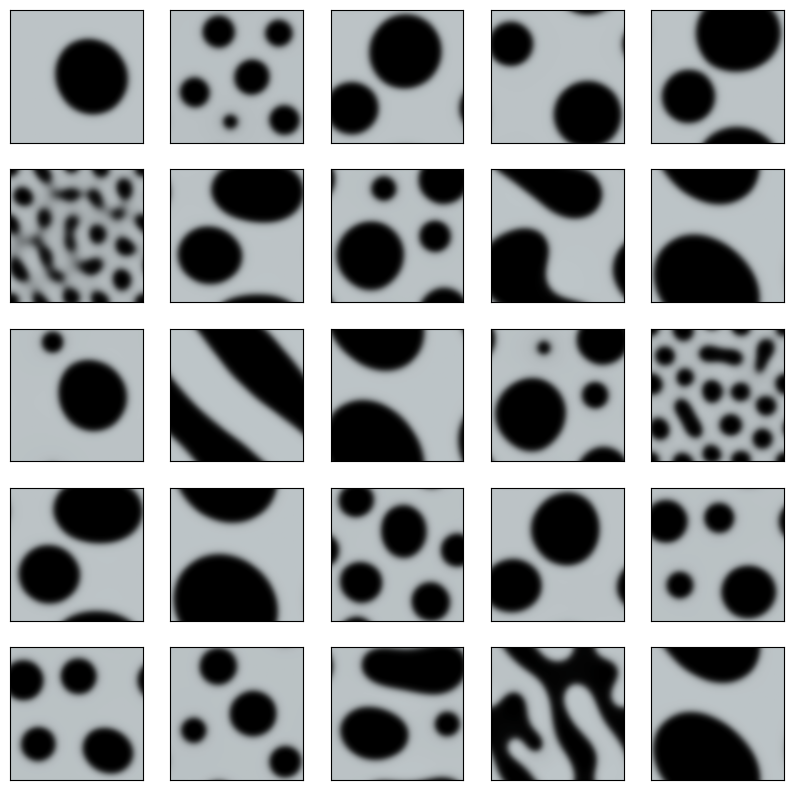

In [ ]:
from sklearn.model_selection import train_test_split

#dividing into train and test sets

train_data, test_data = train_test_split(train_images, train_size=0.8, test_size=0.1, random_state=42, shuffle=True)
print(train_data.shape)

print(test_data.shape)
#plotting the figures of the train set

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i])
plt.show()


In [ ]:
tf.keras.backend.clear_session()

In [ ]:

# from keras.layers.preprocessing import string_lookup
model = tf.keras.Sequential()

#Designing the encoder section of the model

model.add(tf.keras.layers.Conv2D(input_shape = (128,128,3), filters= 32, kernel_size = (5,5), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

# (32,32,8)

#Deigning the Decoder section of the model

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5),  activation='sigmoid', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         580       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 4)        0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

checkpoint_filepath = '/content/drive/MyDrive/New_data_Mu2Mech/5th_time_step/Reconstruction_model_4/autoencoder.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
history = model.fit(train_data,
                    train_data,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=8,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_checkpoint_callback,early_stopping, reduce_lr])


Epoch 1/100
400/400 [==============================] - 9s 13ms/step - loss: 0.0313 - accuracy: 0.7368 - val_loss: 0.0037 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 4s 11ms/step - loss: 0.0024 - accuracy: 0.8863 - val_loss: 0.0017 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0011 - accuracy: 0.8925 - val_loss: 8.7924e-04 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 4/100
400/400 [==============================] - 4s 11ms/step - loss: 8.6243e-04 - accuracy: 0.9053 - val_loss: 6.9898e-04 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 5/100
400/400 [==============================] - 4s 11ms/step - loss: 6.8335e-04 - accuracy: 0.8005 - val_loss: 5.4627e-04 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 6/100
400/400 [==============================] - 5s 12ms/step - loss: 5.5674e-04 - accuracy: 0.7180 - val_loss: 4.5949e-04 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 7/100
400/400 [=========

In [ ]:
preds = model.predict(test_data)

16/16 [==============================] - 1s 27ms/step


In [ ]:
score = model.evaluate(preds, test_data)

16/16 [==============================] - 1s 24ms/step - loss: 2.1301e-04 - accuracy: 0.9167


In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("/content/drive/MyDrive/New_models_Mu2Mech/5th_time_step/Reconstruction_model_3/autoencoder.hdf5")

In [ ]:
X = glob.glob("/content/mu2mech_final_data/Test_images/5time_step/0.42%/"+"*.png")
test_images_list = []
from tkinter import Tcl
X_sorted = Tcl().call('lsort', '-dict', X)
test_images_list.append(X_sorted[20])
test_images_list.append(X_sorted[100])
test_images_list.append(X_sorted[200])


#Reshaping the image into proper input dormat for the autoencoder

from PIL import Image
test_images = []

for i,path in enumerate(test_images_list):
  image = cv2.imread(test_images_list[i])
  img = np.array(image)
  img = img.astype("float32") / 255.0
  test_images.append(img)

print(len(test_images))

3


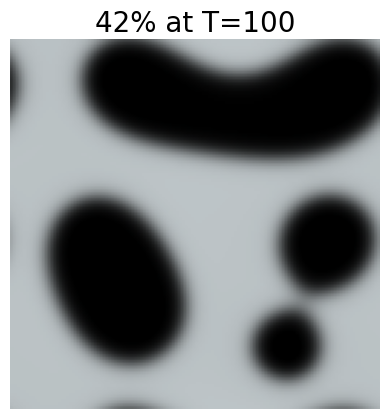

In [ ]:
img = cv2.imread(test_images_list[1])
plt.axis('off')
plt.title('42% at T=100', fontdict={'fontsize':20})
plt.imshow(img)

test_images = np.array(test_images)

1/1 [==============================] - 0s 33ms/step
(3, 128, 128, 3)


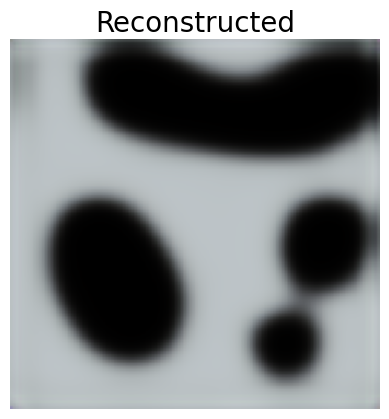

In [ ]:
#predictions

preds = model.predict(test_images)
print(preds.shape)
plt.axis('off')
plt.title('Reconstructed', fontdict={'fontsize':20})
plt.imshow(img)
plt.imshow(preds[1])

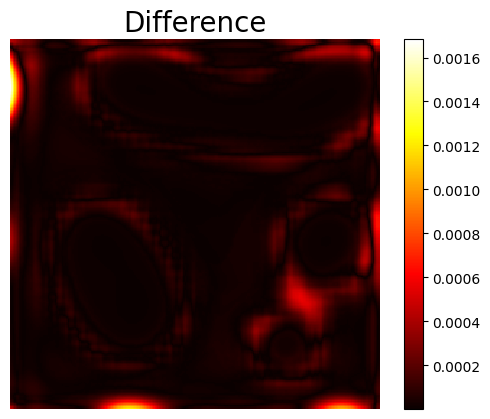

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


# Load the first image
image_1 = test_images[1]

# Load the second image
pred_img_1 = preds[1]

# Convert the NumPy arrays to TensorFlow tensors
image1 = tf.convert_to_tensor(image_1, dtype=tf.float32)
image2 = tf.convert_to_tensor(pred_img_1, dtype=tf.float32)

# Preprocess the images
image1 = tf.image.resize(image1, (256, 256)) / 255.0
image2 = tf.image.resize(image2, (256, 256)) / 255.0

# Calculate the absolute difference between the two images
difference = tf.abs(image1 - image2)

# Convert the difference tensor to grayscale
difference_gray = tf.image.rgb_to_grayscale(difference)

# Reshape the grayscale tensor to a 2D heatmap
heatmap = tf.reshape(difference_gray, (256,256))

# plt.rc('figure', titlesize=25)  # fontsize of the figure title

# Visualize the heatmap

plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.title('Difference', fontdict={'fontsize':20})
plt.show()
